<a href="https://colab.research.google.com/github/Daddypeak/text_tokenization/blob/main/Daddypeak_%EC%9D%8C%EC%84%B1_%ED%95%A9%EC%84%B1(Speech_Synthesis).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 음성 합성(Speech Synthesis)

* https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/Tacotron2

## Tacotron 2

* 텍스트에서 멜 스펙트로그램 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

<img src="https://pytorch.org/assets/images/tacotron2_diagram.png" alt="alt" width="50%"/>

## WaveGlow

* 멜 스펙트로그램에서 음성 생성

* https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/

<img src="https://pytorch.org/assets/images/waveglow_diagram.png" alt="alt" width="50%"/>

In [ ]:
!pip install numpy scipy librosa unidecode inflect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 4.2 MB/s eta 0:00:00


* LJ Speech dataset에서 사전 학습된 Tacotron2와 WaveGlow 모델 로드

In [ ]:
import torch

tacotron2 = torch.hub.load('nvidia/DeepLearningExamples:torchhub','nvidia_tacotron2')
waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub','nvidia_waveglow')
processing = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_tts_utils')

Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub
Using cache found in /root/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [ ]:
tacotron2= tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0-2): 3 x Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (linear_layer): Linear(in_features=80, out_features=256, bias=False)
        )
        (1): LinearNorm(
          (linear_layer): Linear(in_features=256, out_features=256, bias=False)
        )
      )
    )
    (attention_rnn): LSTMCell(768, 1024)
    (attention_layer): Attention(
      (query_layer): LinearNorm(
        (linear_layer): Linear(in_features=1024, out_features=128, bias=False)
      )
      (memory_layer): LinearNorm(
        (linear_layer): Linear(in_fea

In [ ]:
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0-3): 4 x WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0-6): 7 x Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (7

## Text To Speech(TTS)

In [ ]:
# 버전 변경으로 인해 오류
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def plot_data(data, figsize=(16, 4)):
  fig,axes = plt.subplots(1, len(data), figsize=figsize)
  for i in range(len(data)):
    axes[i].imshow(data[i],aspect='auto', origin = 'lower',
                   interpolation = 'none', cmap='viridis')

def TTS(text):

  sampling_rate = 22050

  #sequence = np.array(tacotron2.text_to_sequence(text, ['english_cleaners']))[None, :]
  #sequence = torch.from_numpy(sequence).to(device='cuda',dtype=torch.int64)
  sequence, input_lengths = processing.prepare_input_sequence([text])

  with torch.no_grad():
    #mel_outputs, mel_outputs_postnet, _, alignments = tacotron2.infer(sequence)
    mel_outputs_postnet, mel_lengths, alignments= tacotron2.infer(sequence, input_lengths)  # 이걸로 바꾸고 input_lengths 를 추가하고
    audio = waveglow.infer(mel_outputs_postnet)

  #mel_output = mel_outputs.data.cpu().numpy()[0]
  mel_output_postnet = mel_outputs_postnet.data.cpu().numpy()[0]
  alignment = alignments.data.cpu().numpy()[0].T
  audio_np = audio[0].data.cpu().numpy()

  return mel_output_postnet, alignment, audio_np, sampling_rate
  #return mel_output, mel_output_postnet, alignment, audio_np, sampling_rate

<ipython-input-26-864c79835c8a>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


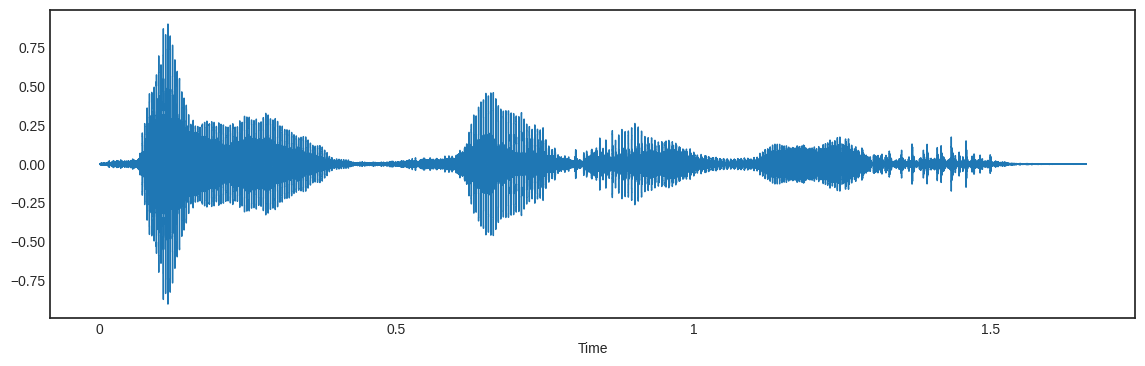

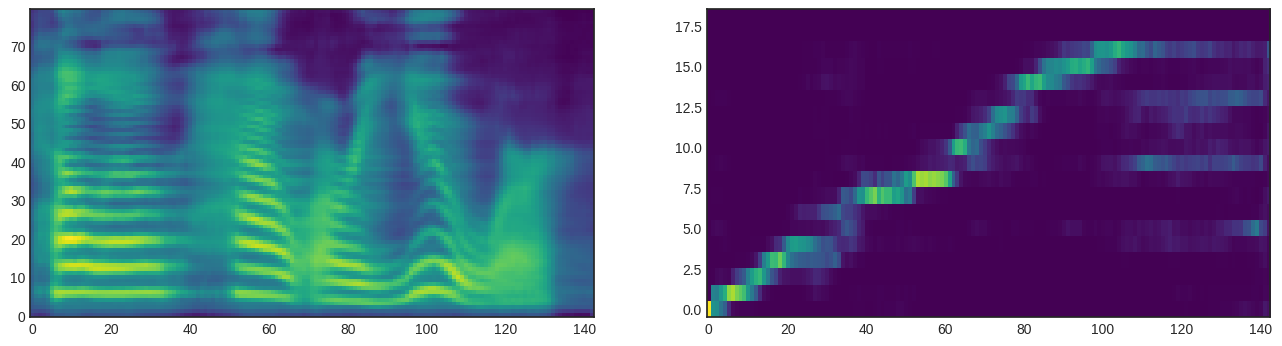

In [ ]:
import librosa.display
from IPython.display import Audio

text = "Hello, how are you?"
#mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure (figsize =(14, 4))
librosa.display.waveshow(audio_np, sr = sampling_rate)
plot_data((mel_output_postnet, alignment))
#plot_data((mel_output, mel_output_postnet, alignment))
Audio(audio_np, rate = sampling_rate)

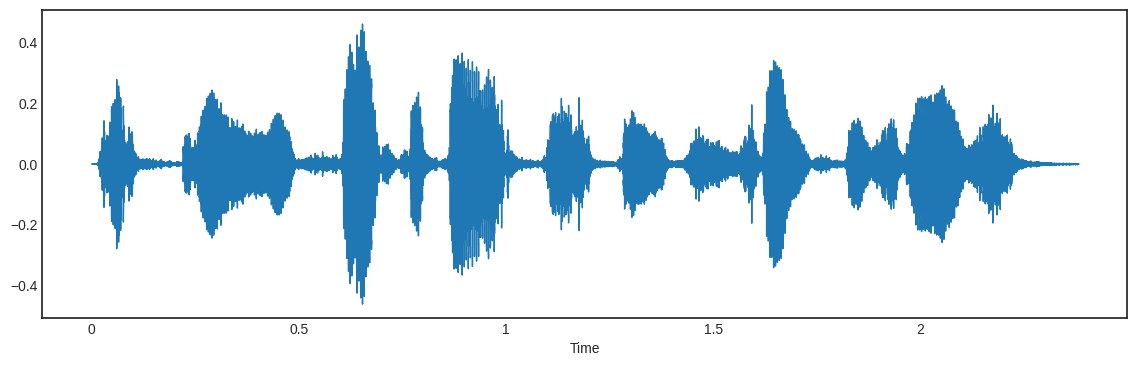

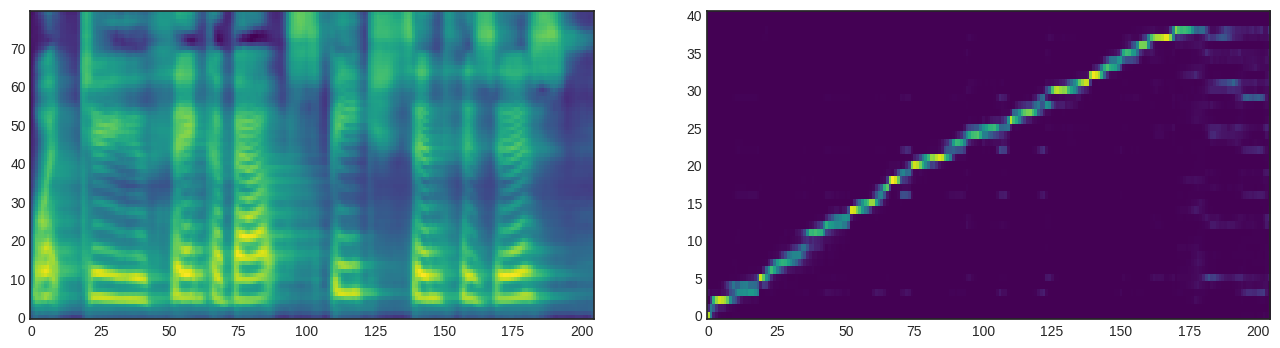

In [ ]:
text = "What do you think about speech synthesis?"
#mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure (figsize =(14, 4))
librosa.display.waveshow(audio_np, sr = sampling_rate)
plot_data((mel_output_postnet, alignment))
#plot_data((mel_output, mel_output_postnet, alignment))
Audio(audio_np, rate = sampling_rate)

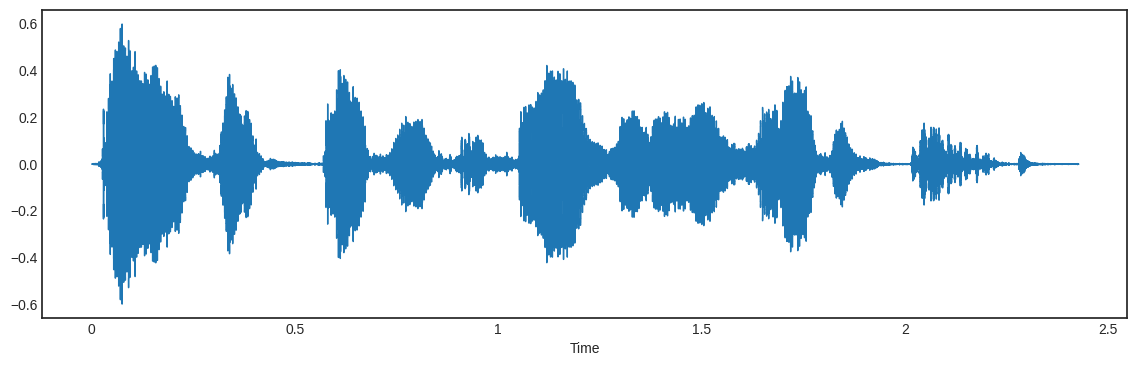

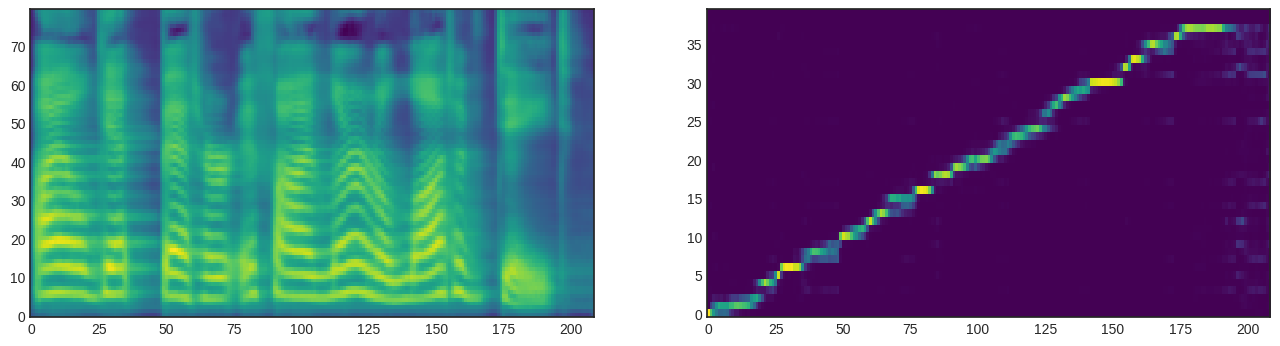

In [ ]:
text = "I'll get better if I learn a lot of data"
#mel_output, mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)
mel_output_postnet, alignment, audio_np, sampling_rate = TTS(text)

fig = plt.figure (figsize =(14, 4))
librosa.display.waveshow(audio_np, sr = sampling_rate)
plot_data((mel_output_postnet, alignment))
#plot_data((mel_output, mel_output_postnet, alignment))
Audio(audio_np, rate = sampling_rate)